# Graph Convolutional Network

In [10]:
import torch
import torch_geometric
import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Twitch, GitHub, GNNBenchmarkDataset
import networkx as nkx

DEVICE = torch.device('cpu')

## Model

In [11]:
class GCN(nn.Module):
    def __init__(self, n: int):
        """
        n: int - number of input features of nodes
        """
        super().__init__()
        self.conv1 = pyg_nn.GCNConv(n, n // 4)
        self.conv2 = pyg_nn.GCNConv(n // 4, n // 8)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        return x


class MLP(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        d1 = int(n**0.5)
        self.layer1 = nn.Linear(n, d1)
        self.layer2 = nn.Linear(d1, 1)
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return torch.sigmoid(x)


class GcnMlpClassifier(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.gcn = GCN(n)
        self.mlp = MLP(n // 8)

    def forward(self, data):
        x = self.gcn(data)
        outs = self.mlp(x)
        return outs

## Training

In [12]:
github = GitHub(root='../data/GitHub')
github

GitHub()

100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


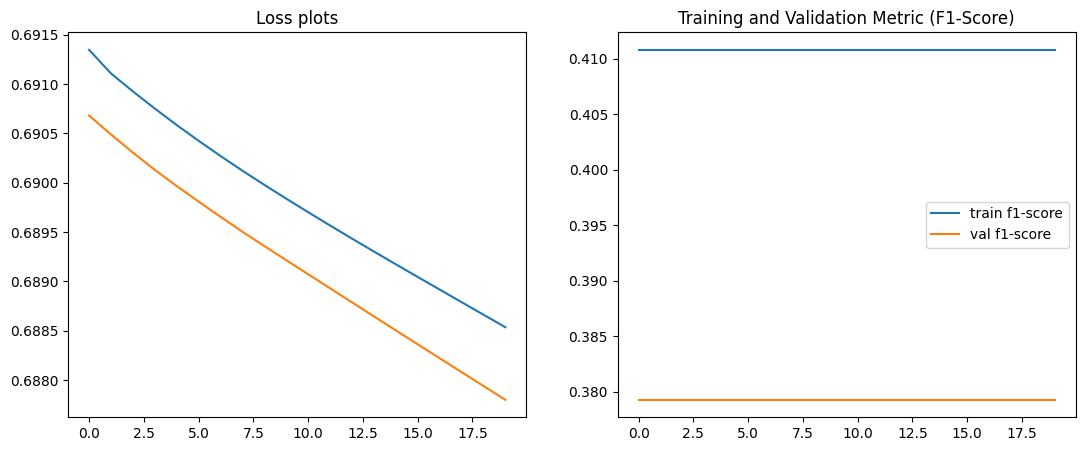

In [13]:
from common import train_model, eval_model, plot_hist

from torch_geometric.transforms import RandomNodeSplit
torch.manual_seed(42)

model = GcnMlpClassifier(github.num_features).to(DEVICE)
data = RandomNodeSplit()(github.data.to(DEVICE)) # for loss computation
data.y = data.y.to(torch.float)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
loss = nn.BCELoss()

train_hist = train_model(model, criterion=loss, optimizer=optimizer, data=data, epochs=20, device=DEVICE, log_stats=False)
plot_hist(train_hist)

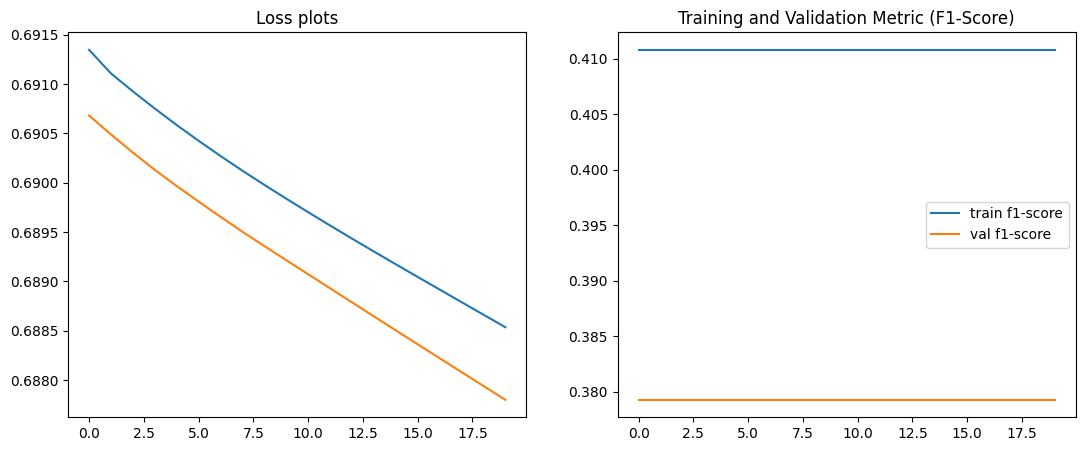

In [14]:
from common import plot_hist

plot_hist(train_hist)

In [115]:
twitch = Twitch(root='../data/Twitch', name='EN')
twitch.data

Processing...
Done!


Data(x=[7126, 128], edge_index=[2, 77774], y=[7126])

  1%|          | 17/2000 [00:00<00:23, 84.23it/s]


epoch 0:
tr_loss 0.6935
tr_acc: 0.4623                                 
val_acc: 0.5000


 11%|█         | 216/2000 [00:02<00:19, 90.28it/s]


epoch 200:
tr_loss 0.4759
tr_acc: 0.7970                                 
val_acc: 0.5740


 21%|██        | 412/2000 [00:04<00:17, 89.12it/s]


epoch 400:
tr_loss 0.3446
tr_acc: 0.8718                                 
val_acc: 0.5560


 31%|███       | 611/2000 [00:06<00:16, 84.03it/s]


epoch 600:
tr_loss 0.2828
tr_acc: 0.8967                                 
val_acc: 0.5560


 41%|████      | 815/2000 [00:09<00:15, 75.60it/s]


epoch 800:
tr_loss 0.2417
tr_acc: 0.9028                                 
val_acc: 0.5560


 51%|█████     | 1015/2000 [00:12<00:14, 70.34it/s]


epoch 1000:
tr_loss 0.2088
tr_acc: 0.9108                                 
val_acc: 0.5680


 60%|██████    | 1209/2000 [00:14<00:10, 76.86it/s]


epoch 1200:
tr_loss 0.1827
tr_acc: 0.9118                                 
val_acc: 0.5680


 71%|███████   | 1411/2000 [00:17<00:07, 74.98it/s]


epoch 1400:
tr_loss 0.1660
tr_acc: 0.9127                                 
val_acc: 0.5620


 81%|████████  | 1618/2000 [00:19<00:04, 85.23it/s]


epoch 1600:
tr_loss 0.1512
tr_acc: 0.9387                                 
val_acc: 0.5440


 91%|█████████ | 1815/2000 [00:22<00:02, 87.10it/s]


epoch 1800:
tr_loss 0.1419
tr_acc: 0.9410                                 
val_acc: 0.5380


100%|██████████| 2000/2000 [00:24<00:00, 81.20it/s]


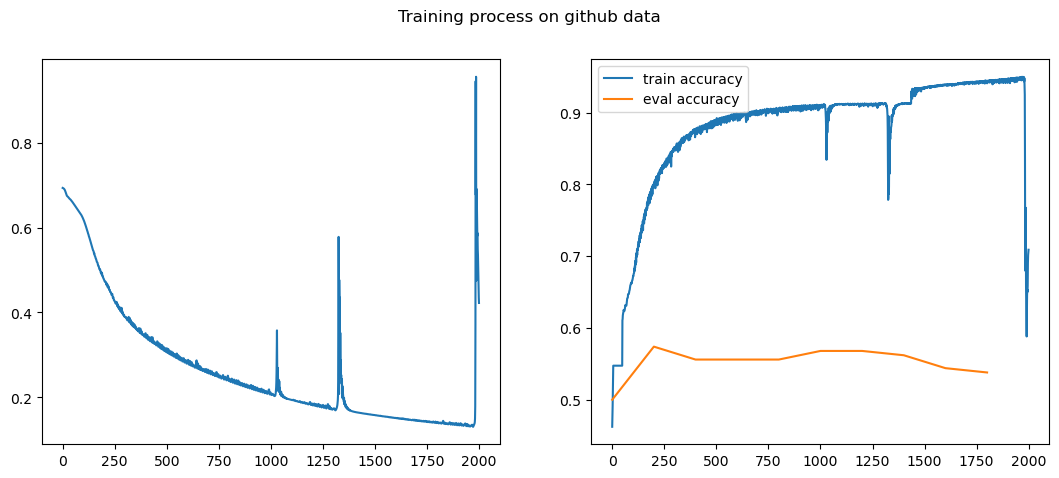

In [137]:
torch.manual_seed(42)

model = GcnMlpClassifier(twitch.num_features).to(DEVICE)
data = RandomNodeSplit()(twitch.data.to(DEVICE))
data.y = data.y.to(torch.float32) # for loss computation
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-3)
loss = nn.BCELoss()

train_hist = train_model(model, loss, optimizer, data, epochs=2000, eval_freq=200)
plot_hist(*train_hist, eval_freq=200)

## Benchmarks